In [11]:
#!pip install pyvista
#!pip install pyvista[jupyter]
#!pip install pyvistaqt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
from pyvistaqt import BackgroundPlotter
import time as time
from skimage.measure import marching_cubes
import nibabel as nib
from nibabel.processing import resample_from_to
import imageio
import pickle
from scipy.optimize import brentq
pv.set_jupyter_backend('none')    # if you want the trame-based UI

def print_data(mesh):
    print(mesh.point_data)
    print(mesh.cell_data)
    print(mesh.field_data)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

def save_pickle(obj, path):
    path = Path(path)
    tmp = path.with_suffix(path.suffix + ".tmp")
    with open(tmp, "wb") as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    os.replace(tmp, path)  # atomic replace

In [22]:
from dataclasses import dataclass, field
import numpy as np, pyvista as pv, uuid

def make_edge_dict(mesh):
    """
    Extract edge data from a mesh from vertex and face lists.
    Returns a dictionary with each edge as a key in the form
    of a sorted tuple, [(v0, v1)] if v0 < v1, [(v1, v0)] if v1 < v0.
    Each key/edge will contain another dictionary with keys:
    [opposite_vertex_0 : int, opposite_vertex_1 : int, 
     weight (w = cot(opposite_angle_0) + cot(opposite_angle_1)) : float]

     Parameters
     ----------
     mesh : pv.PolyData
     
     Returns
     -------
     edge_dict : dictionary
         Contains a dict for each edge [(v0,v1)] with keys opposite_vertex_0,
         opposite_vertex_1, and weight. opposite_vertex_i contains
         float of the angle in radians made by the three vertices
         v0, opposite_vertex_i, v1
    """
    verts = mesh.points
    faces = mesh.faces
    edge_dict = {}
    if faces.ndim == 1:
        faces = faces.reshape(-1, 4)
    
    for tri in faces[:,1:]:
        i, j, k = map(int, tri)
        for (a,b,c) in [(i,j,k),(j,k,i),(k,i,j)]:
            e = tuple(sorted((a,b)))   # e.g. (min(a,b),max(a,b))
            if e not in edge_dict:
                edge_dict[e] = {}
            v0 = verts[a]
            v1 = verts[b]
            v2 = verts[c]
            e0 = v0 - v2
            e1 = v1 - v2
            costheta = np.dot(e0, e1) / (np.linalg.norm(e0) * np.linalg.norm(e1) + 1e-15)
            costheta = np.clip(costheta, -1, 1)
            angle = np.arccos(costheta)
            edge_dict[e][c] = float(angle)     # store the vertex “across” this edge
            if len(edge_dict[e]) == 2:
                angle0 = list(edge_dict[e].items())[0][1]
                w = (np.cos(angle0)/(np.sin(angle0) + 1e-15)) + (np.cos(angle)/(np.sin(angle) + 1e-15))
                edge_dict[e]['weight'] = float(w)
    edges_idx = np.array([(i[0], i[1]) for i in edge_dict], dtype=int)
    weights = np.array([edge_dict[i].get('weight', 0.0) for i in edge_dict], dtype=float)

    return edge_dict, edges_idx, weights

def string_energy_vec(edges_idx, weights, phi):
    # # phi: (N,3) array of vertex coords on the sphere
    # phi = mesh['spherical_param']
    # edges_idx = mesh['edges_idx']
    # weights = mesh['edges_weights']
    i0 = edges_idx[:,0]
    i1 = edges_idx[:,1]
    # shape (E,3) differences
    diffs = phi[i0] - phi[i1]
    # squared‐norm per edge, shape (E,)
    sqnorm = np.einsum('ij,ij->i', diffs, diffs)
    # sum w * sqnorm
    return float(np.dot(weights, sqnorm))

def extract_vertex_face_energies(
    verts_sph: np.ndarray,
    faces_pv: np.ndarray,
    edges_idx: np.ndarray,
    weights: np.ndarray,
    *,
    return_means: bool = True
):
    """
    Compute discrete Dirichlet energy contributions of a spherical parameterization.

    Returns
    -------
    eE : (E,) per-edge energy w_ij * ||phi_i - phi_j||^2
    fE : (F,) per-face sum of incident edge energies (split equally among incident faces)
    vE : (V,) per-vertex sum of incident edge energies (split 0.5 to each endpoint)
    (optionally) fE_mean, vE_mean : means normalized by incidence counts
    """
    # faces as (F,3)
    faces = faces_pv.reshape(-1, 4)[:, 1:] if faces_pv.ndim == 1 else faces_pv
    V = verts_sph.shape[0]
    F = faces.shape[0]
    E = edges_idx.shape[0]

    # 1) per-edge energy
    i0, i1 = edges_idx[:, 0], edges_idx[:, 1]
    diffs = verts_sph[i0] - verts_sph[i1]               # (E,3)
    len2  = np.einsum('ij,ij->i', diffs, diffs)         # (E,)
    eE    = weights * len2                               # (E,)

    # 2) per-vertex accumulation (split evenly to endpoints)
    vE = np.zeros(V, dtype=float)
    np.add.at(vE, i0, 0.5 * eE)
    np.add.at(vE, i1, 0.5 * eE)

    # 3) per-face accumulation
    # Build a light vertex->faces adjacency to find faces adjacent to each edge
    v2f = [[] for _ in range(V)]
    for fi, (a, b, c) in enumerate(faces):
        v2f[a].append(fi); v2f[b].append(fi); v2f[c].append(fi)

    fE = np.zeros(F, dtype=float)
    face_inc_counts = np.zeros(F, dtype=int)

    for k, (a, b) in enumerate(edges_idx):
        adj = list(set(v2f[a]) & set(v2f[b]))  # 1 (boundary) or 2 (interior)
        if len(adj) == 0:
            # Non-manifold or disconnected edge; skip or assign nowhere
            continue
        share = eE[k] / len(adj)
        for fi in adj:
            fE[fi] += share
            face_inc_counts[fi] += 1

    if not return_means:
        return eE, fE, vE

    # 4) Optional: means normalized by incidence (avoid division by zero)
    # For vertices, count how many incident edges per vertex
    vertex_inc_counts = np.zeros(V, dtype=int)
    np.add.at(vertex_inc_counts, i0, 1)
    np.add.at(vertex_inc_counts, i1, 1)

    with np.errstate(divide='ignore', invalid='ignore'):
        vE_mean = np.where(vertex_inc_counts > 0, vE / vertex_inc_counts, 0.0)
        fE_mean = np.where(face_inc_counts   > 0, fE / face_inc_counts,     0.0)

    return eE, fE_mean, vE_mean


def d_energy_vec(edges_idx, weights, phi):
    """
    Vectorized ∂E/∂Phi for all vertices at once.
    
    edges_idx : (E,2) int array of [i,j] pairs
    weights   : (E,)  float array of w_ij
    phi       : (N,3) float array of Phi positions

    returns grad : (N,3) float array of 2*sum_j w_ij*(Phi_i - Phi_j)
    """
    i0 = edges_idx[:, 0]      # shape = (E,)
    i1 = edges_idx[:, 1]      # shape = (E,)

    # 1) compute the per-edge vector differences
    diffs    = phi[i0] - phi[i1]         # (E,3)

    # 2) weight them
    w_diffs  = diffs * weights[:, None]  # (E,3)

    # 3) scatter‐add into a per-vertex accumulator
    grad     = np.zeros_like(phi)        # (N,3)
    np.add.at(grad, i0,  w_diffs)        # grad[i0] +=  w_diffs
    np.add.at(grad, i1, -w_diffs)        # grad[i1] -=  w_diffs

    # 4) if you want the true energy‐gradient, multiply by 2
    # grad *= 2

    return grad

def C2_adaptive(phi0, edges_idx, weights, *,
                tol=1e-10, max_iter=10_000, initial_dt=0.1):
    """
    Projected gradient descent on S^2 to minimize sum w_ij ||phi_i - phi_j||^2.
    Inputs:
      phi0: (N,3) initial directions (will be normalized)
      edges_idx: (E,2) int
      weights: (E,) float
    Returns:
      phi: (N,3) final S^2 embedding
      energies: list of energy values over iterations
    """
    # normalize just in case
    phi = phi0 / (np.linalg.norm(phi0, axis=1, keepdims=True) + 1e-15)

    E = string_energy_vec(edges_idx, weights, phi)
    energies = [E]
    dt = float(initial_dt)

    for it in range(1, max_iter+1):
        g = d_energy_vec(edges_idx, weights, phi)
        # project gradient onto tangent space
        g_proj = g - (np.einsum('ij,ij->i', g, phi))[:, None] * phi

        ok = False
        dt_try = dt
        for _ in range(6):
            phi_try = phi - dt_try * g_proj
            phi_try /= (np.linalg.norm(phi_try, axis=1, keepdims=True) + 1e-15)
            E_try = string_energy_vec(edges_idx, weights, phi_try)
            if E_try < E:
                phi, E = phi_try, E_try
                energies.append(E)
                dt = min(dt_try * 1.25, 1.0)
                ok = True
                break
            dt_try *= 0.25

        if not ok or (energies[-2] - energies[-1]) < tol:
            break

    return phi, energies


def srnf_from_mesh(mesh):
    mesh.compute_normals(point_normals=False, cell_normals=True, inplace=True)
    mesh['Area'] = mesh.compute_cell_sizes(length=False, area=True, volume=False)['Area']
    u = mesh.cell_data["Normals"]                # (F, 3)
    A = mesh.cell_data["Area"]                  # (F,)
    q = u * np.sqrt(2.0 * A)[:, None]           # (F, 3)
    return q

def spherical_triangle_area(a, b, c):
    # a,b,c: (M,3) unit vectors; returns (M,) steradians
    num = np.abs(np.einsum('ij,ij->i', a, np.cross(b, c)))
    den = 1.0 + np.einsum('ij,ij->i', a, b) \
              + np.einsum('ij,ij->i', b, c) \
              + np.einsum('ij,ij->i', c, a)
    return 2.0 * np.arctan2(num, den)

def icosphere_quadrature(nsub=3, radius=1.0):
    ico = pv.Icosphere(nsub=nsub, radius=radius)
    F = ico.faces.reshape(-1, 4)[:, 1:]         # (M,3)
    P = ico.points                               # (Nv,3) ~ unit vectors
    tri = P[F]                                   # (M,3,3)
    centers = tri.mean(axis=1)
    centers /= np.linalg.norm(centers, axis=1, keepdims=True)
    areas = spherical_triangle_area(tri[:,0], tri[:,1], tri[:,2]) * (radius**0)  # already on sphere
    # sanity: areas.sum() ≈ 4π * (radius**2)
    return centers, areas
    
def get_icosphere_level(A, B, nsub):
    if nsub in A.icosphere:
        return A.icosphere[nsub]['points'], A.icosphere[nsub]['weights']
    if nsub in B.icosphere:
        return B.icosphere[nsub]['points'], B.icosphere[nsub]['weights']
    U, w = icosphere_quadrature(nsub)  # (M,3), (M,)
    A.icosphere[nsub] = {'points': U, 'weights': w}
    B.icosphere[nsub] = {'points': U, 'weights': w}
    return U, w

def l2_q(qA, qB, w):
    d = qA - qB
    return float(np.dot(w, np.einsum('ij,ij->i', d, d)))

# ... keep your helpers as provided above ...
def l2(A: "SquareRootNormalMesh", B: "SquareRootNormalMesh", nsub = 5):
    sample_points, sample_weights = get_icosphere_level(A, B, nsub)
    if B.uid not in A.alignments.keys():
        A.get_alignment(B)
    mobius_parameters = A.alignments[B.uid]['mobius_params']
    R = A.alignments[B.uid]['space_rotation']
    sample_reparam, sqrtJ = mobius_apply_on_sphere(sample_points, mobius_parameters)

    q1 = A.sample(sample_points)
    gamma_q2 = B.sample(sample_reparam)
    R_gamma_q2 = (gamma_q2 @ R.T) * sqrtJ[:, None]
    
    l2_sq = l2_q(q1, R_gamma_q2, sample_weights)

    return l2_sq

def stereographic_project(P):  # P: (N,3) unit vectors
    X, Y, Z = P[:,0], P[:,1], P[:,2]
    denom = 1.0 - Z
    # guard near north pole: denom -> 0 => z -> ∞
    denom = np.where(np.abs(denom) < 1e-15, 1e-15, denom)
    return (X + 1j*Y) / denom  # complex array (N,)

def stereographic_unproject(w):  # w: (N,) complex -> (N,3) unit vectors
    x = np.real(w); y = np.imag(w)
    r2 = x*x + y*y
    denom = 1.0 + r2
    P = np.stack([2*x/denom, 2*y/denom, (r2 - 1.0)/denom], axis=1)
    # numeric safety
    P /= np.linalg.norm(P, axis=1, keepdims=True)
    return P

def mobius_apply_on_sphere(P, mobius_params):
    """
    P: (M,3) unit sphere points
    returns: P_gamma (M,3), sqrtJ (M,)
    """
    a, b, c, d = mobius_params
    z = stereographic_project(P)            # (M,) complex
    czd = c*z + d
    w = (a*z + b) / (czd)               # (M,) complex
    P_gamma = stereographic_unproject(w)    # (M,3)

    # sqrt(J) on the sphere (see derivation in the message)
    num = 1.0 + (z.real**2 + z.imag**2)
    den = 1.0 + (w.real**2 + w.imag**2)
    den2 = np.maximum(np.abs(czd)**2, 1e-15)
    sqrtJ = (num/den) / den2      # (M,)
    return P_gamma, sqrtJ
    
def compute_alignment(A: "SquareRootNormalMesh", B: "SquareRootNormalMesh", nsub = 5, n = 500):
    """
    q1_sampler, q2_sampler: callables U->q(U)
    C:   (M,3) fixed base quadrature points on S²
    A:   (M,)  fixed area weights
    mobius_params: (tx, ty, s)  # KAN: translate+scale in plane; rotation lives in R_dom
    R_dom: optional (3,3) domain rotation (SO(3))
    returns: (L2_sq, R_space)
    """
    sample_points, sample_weights = get_icosphere_level(A, B, nsub)
    def kabsch_rotation_srnf(Q1, Q2, weights=None, proper_rotation = True):
        # Q1,Q2 shape (N,3); each row is a vector; rows correspond
        if weights is None:
            w = np.ones(len(Q1))
        else:
            w = np.asarray(weights, float)
        w = w / w.sum()            # normalization doesn't change R, just scales Σ
    
        C = Q1.T @ (Q2 * w[:, None])        # 3x3
        U, S, Vt = np.linalg.svd(C, full_matrices=False)
        R = U @ Vt                           # = U V^T
        if proper_rotation and np.linalg.det(R) < 0:  # reflection fix
            U[:, -1] *= -1
            R = U @ Vt
        return R
        
    def sample_unit_quat():
        # Method B: 3 uniforms → unit quaternion (uniform on SO(3))
        u1, u2, u3 = np.random.rand(3)
        theta1 = 2*np.pi*u2
        theta2 = 2*np.pi*u3
        r1 = np.sqrt(1 - u1)
        r2 = np.sqrt(u1)
        w = r2*np.cos(theta2)
        x = r1*np.sin(theta1)
        y = r1*np.cos(theta1)
        z = r2*np.sin(theta2)
        return w, x, y, z
    
    def su2_from_quat(w, x, y, z):
        alpha = w + 1j*z
        beta  = y + 1j*x
        s = np.sqrt((alpha*alpha.conjugate()).real + (beta*beta.conjugate()).real)
        alpha /= s; beta /= s
        return np.array([[alpha, beta],
                         [-beta.conjugate(), alpha.conjugate()]], dtype=np.complex128)
    
    def sample_similarity_params(smin=-1.0, smax=1.0, T=1.5):
        s = np.random.uniform(smin, smax)          # log-scale
        theta = np.random.uniform(0.0, 2*np.pi)    # in-plane spin
        u = np.random.uniform(0.0, 1.0)
        phi = np.random.uniform(0.0, 2*np.pi)
        r = np.sqrt(u)*T                            # translation radius
        t = r * np.exp(1j*phi)                      # complex translation
        lam = np.exp(s + 1j*theta)                  # complex scale+spin
        return lam, t
    
    def sample_mobius_matrix():
        # 1) domain rotation
        w,x,y,z = sample_unit_quat()
        Mrot = su2_from_quat(w,x,y,z)  # [[α, β], [-β*, α*]]
    
        # 2) plane similarity
        lam, t = sample_similarity_params()
        Msim = np.array([[lam, lam*t],
                         [0+0j, 1+0j]], dtype=np.complex128)
    
        # 3) compose: rotate sphere, then plane similarity
        M = Msim @ Mrot
    
        # 4) optional normalization (det = 1)
        det = M[0,0]*M[1,1] - M[0,1]*M[1,0]
        if np.abs(det) > 1e-15:
            M /= np.sqrt(det)
    
        a, b = M[0,0], M[0,1]
        c, d = M[1,0], M[1,1]
        return a, b, c, d

    best_l2 = 1e10
    best_mobius = np.zeros(4, dtype=np.complex128)
    best_space_rotation = np.eye(3)
    for i in range(n):
        mobius_params = sample_mobius_matrix()
        sample_points_trans, sqrtJ = mobius_apply_on_sphere(sample_points, mobius_params)
        q1 = A.sample(sample_points)
        gamma_q2 = B.sample(sample_points_trans) * sqrtJ[:, None]
        R = kabsch_rotation_srnf(q1, gamma_q2, sample_weights)
        R_gamma_q2 = (gamma_q2 @ R.T)

        l2_sq = l2_q(q1, R_gamma_q2, sample_weights)
        if l2_sq < best_l2:
            best_l2 = l2_sq
            best_mobius = mobius_params
            best_space_rotation = R
    return best_mobius, best_space_rotation, best_l2


@dataclass
class SquareRootNormalMesh:
    verts: np.ndarray
    verts_sph: np.ndarray
    faces_pv:  np.ndarray
    q_face:    np.ndarray
    name: str = ""
    uid:  str = field(default_factory=lambda: uuid.uuid4().hex)

    mesh: pv.PolyData = field(init=False, repr=False)
    mesh_sph: pv.PolyData = field(init=False, repr=False)

    edge_dict: dict = field(init=False, repr=False)
    edge_array: np.ndarray = field(init=False, repr=False)
    edge_weights: np.ndarray = field(init=False, repr=False)

    sphere_param_edge_energy: np.ndarray = field(init=False, repr=False)
    sphere_param_face_energy_mean: np.ndarray = field(init=False, repr=False)
    sphere_param_vertex_energy_mean: np.ndarray = field(init=False, repr=False)
    sphere_param_log: list = field(default_factory=list)
    icosphere: dict = field(default_factory=dict)
    alignments: dict = field(default_factory=dict)
    pairwise_l2: dict = field(default_factory=dict)

    def __post_init__(self):
        self.mesh_sph = pv.PolyData(self.verts_sph, self.faces_pv)

    @classmethod
    def from_polydata(cls, pv_mesh: pv.PolyData, *, max_iter=5000, name=""):
        # build edges/weights
        edge_dict, edge_array, edge_weight = make_edge_dict(pv_mesh)

        # ensure point normals exist and normalize as φ0 ∈ S²
        m = pv_mesh.copy()
        m.compute_normals(point_normals=True, cell_normals=False, inplace=True)
        phi0 = m.point_normals
        phi0 = phi0 / (np.linalg.norm(phi0, axis=1, keepdims=True) + 1e-15)

        # optimize on S²
        verts_sph, logE = C2_adaptive(phi0, edge_array, edge_weight, max_iter=max_iter)

        faces_pv = pv_mesh.faces
        q_face = srnf_from_mesh(pv_mesh)

        # construct
        obj = cls(
            verts=pv_mesh.points.copy(),
            verts_sph=verts_sph,
            faces_pv=faces_pv.copy(),
            q_face=q_face,
            name=name
        )
        obj.edge_dict = edge_dict
        obj.edge_array = edge_array
        obj.edge_weights = edge_weight
        obj.mesh = pv_mesh
        obj.mesh_sph = pv.PolyData(verts_sph, faces_pv)

        # energies (NOTE: your function aggregates weights, not energy)
        eE, fE, vE = extract_vertex_face_energies(verts_sph, faces_pv, edge_array, edge_weight)
        obj.sphere_param_edge_energy = eE
        obj.sphere_param_face_energy_mean = fE
        obj.sphere_param_vertex_energy_mean = vE
        obj.sphere_param_log = logE
        return obj

    @classmethod
    def from_voxels(cls, vox: np.ndarray, *, iso=0.5, spacing=(1,1,1), smoothing=None, **kw):
        from skimage.measure import marching_cubes
        v,f,_,_ = marching_cubes(vox, level=iso, spacing=spacing)
        faces_pv = np.c_[np.full((len(f),1),3,np.int32), f.astype(np.int32)].ravel()
        pv_mesh = pv.PolyData(v, faces_pv)
        if smoothing: pv_mesh = pv_mesh.smooth(n_iter=smoothing)
        return cls.from_polydata(pv_mesh, **kw)

    def sample(self, U: np.ndarray) -> np.ndarray:
        idx = self.mesh_sph.find_closest_cell(U)
        return self.q_face[idx]

    def preindex(self, U: np.ndarray) -> np.ndarray:
        return self.mesh_sph.find_closest_cell(U)

    def gather(self, idx: np.ndarray) -> np.ndarray:
        return self.q_face[idx]

    def get_alignment(self, B: "SquareRootNormalMesh", nsub: int = 5, n: int = 500) -> None:
        output = compute_alignment(self, B, nsub, n)
        self.alignments[B.uid] = {'mobius_params': output[0], 'space_rotation': output[1]}
        self.pairwise_l2[B.uid] = output[2]
        B.pairwise_l2[self.uid] = output[2]

    def plot(self, scalars: np.ndarray = None, cmap: str = "coolwarm") -> None:
        if scalars is None:
            scalars = np.arange(self.verts.shape[0])
        p = BackgroundPlotter()
        p.add_mesh(self.mesh, cmap = cmap, scalars = scalars)
        p.show()

In [14]:
d1_file = "C:/Users/colli/Documents/Thesis/data/d1/d1.nii"
d1_image = nib.load(d1_file)
d1_mat = d1_image.get_fdata()
d1_seg_file = "C:/Users/colli/Documents/Thesis/data/d1/seg/segmented_seg.nii"
d1_seg_image = nib.load(d1_seg_file)
d1_seg_mat = d1_seg_image.get_fdata()

mask_file = "//wsl.localhost/Ubuntu-22.04/home/colli/jo/corpus_callosum_mask.nii.gz"
mask_image = nib.load(mask_file)
mask_resample = nib.processing.resample_from_to(mask_image, d1_seg_image)
mask_mat = mask_resample.get_fdata()
mask_mat[np.where(mask_mat < 0.5)] = 0
mask_mat[np.where(mask_mat >= 0.5)] = 1

verts, faces, normals, values = marching_cubes(mask_mat)
col = np.full((faces.shape[0], 1), 3)
raw_cc_mesh = pv.PolyData(verts, np.hstack((col, faces)).flatten())
cc_mesh = raw_cc_mesh.smooth(n_iter = 500, relaxation_factor = 0.005)

cc_srnm = SquareRootNormalMesh.from_polydata(cc_mesh)

def prep_for_param(mesh: pv.PolyData, target_tris=None, seal=True) -> pv.PolyData:
    m = mesh.triangulate().clean().compute_normals(inplace=False)
    if seal:
        m = m.fill_holes(1e6).extract_largest().clean()
    # optional: decimate or subdivide to a comfortable triangle count
    if target_tris is not None:
        if m.n_cells > target_tris:
            frac = 1 - target_tris / m.n_cells
            m = m.decimate_pro(fraction=frac, preserve_topology=True)
        else:
            # Loop subdivision for smoother sampling
            iters = max(1, int(np.ceil(np.log2(target_tris / m.n_cells))))
            m = m.subdivide(nsub=iters, subfilter='loop')
    return m.compute_normals(inplace=False)

shark_mesh = pv.examples.download_great_white_shark()
shark_mesh = prep_for_param(shark_mesh)

shark_srnm = SquareRootNormalMesh.from_polydata(shark_mesh)

TypeError: SquareRootNormalMesh.__init__() missing 3 required positional arguments: 'verts_sph', 'faces_pv', and 'q_face'

In [33]:
start = time.time()
cc_srnm.get_alignment(shark_srnm)
end = time.time()
print(end - start)

177.28600573539734


In [53]:
cc_srnm.pairwise_l2

{'897a72708c054bddb787673a0c6d4636': 6.252765175463404}

In [43]:
start = time.time()
l2_list = []
mobius_list = []
space_rotation_list = []
proper_rotation_list = []

def compute_alignment(A: "SquareRootNormalMesh", B: "SquareRootNormalMesh", nsub = 5, n = 500):
    """
    q1_sampler, q2_sampler: callables U->q(U)
    C:   (M,3) fixed base quadrature points on S²
    A:   (M,)  fixed area weights
    mobius_params: (tx, ty, s)  # KAN: translate+scale in plane; rotation lives in R_dom
    R_dom: optional (3,3) domain rotation (SO(3))
    returns: (L2_sq, R_space)
    """
    sample_points, sample_weights = get_icosphere_level(A, B, nsub)
    def kabsch_rotation_srnf(Q1, Q2, weights=None, proper_rotation = True):
        # Q1,Q2 shape (N,3); each row is a vector; rows correspond
        if weights is None:
            w = np.ones(len(Q1))
        else:
            w = np.asarray(weights, float)
        w = w / w.sum()            # normalization doesn't change R, just scales Σ
    
        C = Q1.T @ (Q2 * w[:, None])        # 3x3
        U, S, Vt = np.linalg.svd(C, full_matrices=False)
        R = U @ Vt                           # = U V^T
        if proper_rotation and np.linalg.det(R) < 0:  # reflection fix
            U[:, -1] *= -1
            R = U @ Vt
        return R
        
    def sample_unit_quat():
        # Method B: 3 uniforms → unit quaternion (uniform on SO(3))
        u1, u2, u3 = np.random.rand(3)
        theta1 = 2*np.pi*u2
        theta2 = 2*np.pi*u3
        r1 = np.sqrt(1 - u1)
        r2 = np.sqrt(u1)
        w = r2*np.cos(theta2)
        x = r1*np.sin(theta1)
        y = r1*np.cos(theta1)
        z = r2*np.sin(theta2)
        return w, x, y, z
    
    def su2_from_quat(w, x, y, z):
        alpha = w + 1j*z
        beta  = y + 1j*x
        s = np.sqrt((alpha*alpha.conjugate()).real + (beta*beta.conjugate()).real)
        alpha /= s; beta /= s
        return np.array([[alpha, beta],
                         [-beta.conjugate(), alpha.conjugate()]], dtype=np.complex128)
    
    def sample_similarity_params(smin=-1.0, smax=1.0, T=1.5):
        s = np.random.uniform(smin, smax)          # log-scale
        theta = np.random.uniform(0.0, 2*np.pi)    # in-plane spin
        u = np.random.uniform(0.0, 1.0)
        phi = np.random.uniform(0.0, 2*np.pi)
        r = np.sqrt(u)*T                            # translation radius
        t = r * np.exp(1j*phi)                      # complex translation
        lam = np.exp(s + 1j*theta)                  # complex scale+spin
        return lam, t
    
    def sample_mobius_matrix():
        # 1) domain rotation
        w,x,y,z = sample_unit_quat()
        Mrot = su2_from_quat(w,x,y,z)  # [[α, β], [-β*, α*]]
    
        # 2) plane similarity
        lam, t = sample_similarity_params()
        Msim = np.array([[lam, lam*t],
                         [0+0j, 1+0j]], dtype=np.complex128)
    
        # 3) compose: rotate sphere, then plane similarity
        M = Msim @ Mrot
    
        # 4) optional normalization (det = 1)
        det = M[0,0]*M[1,1] - M[0,1]*M[1,0]
        if np.abs(det) > 1e-15:
            M /= np.sqrt(det)
    
        a, b = M[0,0], M[0,1]
        c, d = M[1,0], M[1,1]
        return a, b, c, d

    best_l2 = 1e10
    best_mobius = np.zeros(4, dtype=np.complex128)
    best_space_rotation = np.eye(3)
    for i in range(n):
        mobius_params = sample_mobius_matrix()
        sample_points_trans, sqrtJ = mobius_apply_on_sphere(sample_points, mobius_params)
        q1 = A.sample(sample_points)
        gamma_q2 = B.sample(sample_points_trans) * sqrtJ[:, None]
        proper_rotation = np.random.choice([True, False], p=[0.7,0.3])
        R = kabsch_rotation_srnf(q1, gamma_q2, sample_weights, proper_rotation=proper_rotation)
        R_gamma_q2 = (gamma_q2 @ R.T)

        l2_sq = l2_q(q1, R_gamma_q2, sample_weights)

        mobius_list.append(mobius_params)
        space_rotation_list.append(R)
        l2_list.append(l2_sq)
        proper_rotation_list.append(proper_rotation)
        if l2_sq < best_l2:
            best_l2 = l2_sq
            best_mobius = mobius_params
            best_space_rotation = R
    return best_mobius, best_space_rotation, best_l2
joopy = compute_alignment(cc_srnm, shark_srnm)
end = time.time()
print(end - start, joopy)

115.38422441482544 ((np.complex128(-0.38482973421032823-0.13191117810055766j), np.complex128(-0.8033430550235474-0.4727060988055343j), np.complex128(0.9886547942135376-0.43261881662722224j), np.complex128(0.09253882575514308+0.27959098255093684j)), pyvista_ndarray([[-0.62545648, -0.76450215,  0.15601493],
                 [-0.78025004,  0.61377983, -0.1203503 ],
                 [-0.00375075, -0.19700453, -0.9803954 ]]), 5.462345714456904)


In [64]:
mobius_list[30]

(np.complex128(-0.38482973421032823-0.13191117810055766j),
 np.complex128(-0.8033430550235474-0.4727060988055343j),
 np.complex128(0.9886547942135376-0.43261881662722224j),
 np.complex128(0.09253882575514308+0.27959098255093684j))

In [66]:
icospho = pv.Icosphere(nsub = 6)
icospho_trans_546, sqrtj546 = mobius_apply_on_sphere(icospho.points, mobius_list[30])
icospho_trans_625, sqrtj625 = mobius_apply_on_sphere(icospho.points, cc_srnm.alignments['897a72708c054bddb787673a0c6d4636']['mobius_params'])
scalos = np.arctan2(icospho.points[:,2], icospho.points[:,1])
scalos = (scalos + np.pi) / (2*np.pi)
p = BackgroundPlotter()
p.add_mesh(icospho_trans_546, scalars = scalos, cmap = 'coolwarm')
p.show()
p = BackgroundPlotter()
p.add_mesh(icospho_trans_625, scalars = scalos, cmap = 'viridis')
p.show()

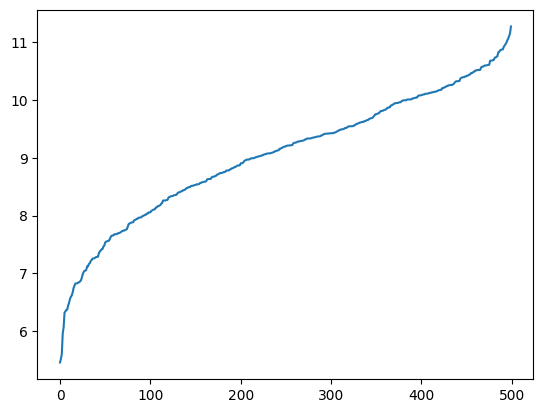

In [51]:
plt.plot(np.sort(l2_list))

In [68]:
joopy[0]

(np.complex128(-0.38482973421032823-0.13191117810055766j),
 np.complex128(-0.8033430550235474-0.4727060988055343j),
 np.complex128(0.9886547942135376-0.43261881662722224j),
 np.complex128(0.09253882575514308+0.27959098255093684j))

In [69]:
cc_srnm.alignments['897a72708c054bddb787673a0c6d4636']['mobius_params']

(np.complex128(0.4483609202142651-0.3191750623003304j),
 np.complex128(-0.807073766484669+0.7317947231992167j),
 np.complex128(0.5443544500101749+0.480822060793308j),
 np.complex128(0.29822525828748503+0.2352633851253439j))

In [88]:
def angle_scalar(P, ax):
    # P: (N,3) unit sphere points
    if ax == 'x':
        phi = np.arctan2(P[:,2], P[:,1])          # angle around x-axis ∈ (-π, π]
    elif ax == 'y':
        phi = (np.arctan2(P[:,0], P[:,2]) + np.pi) / (2*np.pi)  # around y
    else:
        phi = (np.arctan2(P[:,1], P[:,0]) + np.pi) / (2*np.pi)  # around z

    phi = (phi + np.pi) / (2*np.pi)       # map to [0,1] for coloring
    return phi

def long_lat_scalar(P):
    lon = np.arctan2(P[:,1], P[:,0])               # (-π, π]
    lat = np.arcsin(np.clip(P[:,2], -1.0, 1.0))    # (-π/2, π/2)
    
    n_lon, n_lat = 10, 5
    checker = ((np.floor((lon + np.pi) / (2*np.pi) * n_lon).astype(int)
              + np.floor((lat + np.pi/2) / np.pi * n_lat).astype(int)) % 2).astype(float)
    # Colormap: 'gray', 'binary', or 'tab10' for discrete blocks
    return checker

def spiral_scalar(P, ax, k):
    if ax == 'x':
        phase = (np.arctan2(P[:,2], P[:,1]) + k * np.arccos(P[:,0])) % (2*np.pi)
    elif ax == 'y':
        phase = (np.arctan2(P[:,0], P[:,2]) + k * np.arccos(P[:,1])) % (2*np.pi)
    else:
        phase = (np.arctan2(P[:,1], P[:,0]) + k * np.arccos(P[:,2])) % (2*np.pi)
    phase01 = phase / (2*np.pi)  # cyclic colormap
    return phase01

long_lat_scalar(pv.Icosphere(nsub=2).points)


pyvista_ndarray([1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1.,
                 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
                 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
                 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
                 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
                 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
                 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
                 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
                 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1.,
                 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
                 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
                 1., 0., 0., 1., 0., 0., 0., 1.])

In [91]:
p = BackgroundPlotter()
p.add_mesh(icospho, cmap = 'coolwarm', scalars = spiral_scalar(icospho.points, 'z', 20))
p.show()